## Analysis of Past Loseit Challenges

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import praw
import datetime as dt
import markdown
from lxml import etree
import lxml
import gspread
import re
import matplotlib.pyplot as plt
import seaborn as sns
from oauth2client.service_account import ServiceAccountCredentials
from pathlib import Path
import os

sorting

In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

Create the Data Directories

In [3]:
if not os.path.exists('./data/raw_data/'):
    os.makedirs('./data/raw_data/')
if not os.path.exists('./figures/'):
    os.makedirs('./figures/')

In [3]:
reddit = praw.Reddit('loseit_data')

In [4]:
loseit_sub = reddit.subreddit('loseit')
challenge_posts = loseit_sub.search("loseit challenge tracker", limit=1000)
topics_dict = { "title":[], "score":[], "id":[], "url":[], "comms_num": [],
                "created": [], "body":[]}

In [5]:
for submission in challenge_posts:
    topics_dict["title"].append(submission.title)
    topics_dict["score"].append(submission.score)
    topics_dict["id"].append(submission.id)
    topics_dict["url"].append(submission.url)
    topics_dict["comms_num"].append(submission.num_comments)
    topics_dict["created"].append(submission.created)
    topics_dict["body"].append(submission.selftext)

In [6]:
topics_data = pd.DataFrame(topics_dict)

In [7]:
def get_date(created):
    return dt.datetime.fromtimestamp(created)
_timestamp = topics_data["created"].apply(get_date)
topics_data = topics_data.assign(timestamp = _timestamp)

In [8]:
topics_data.to_csv('loseit_search_history.csv')

### Now that we have searched through old loseit posts, we need to find the urls

In [9]:
links = []
for body in topics_dict['body']:
    try:
        doc = etree.fromstring(markdown.markdown(re.sub('[\\n]', '', body)))
        for link in doc.xpath('//a'):
            web_url = link.get('href')
            if bool(re.search('spreadsheet',web_url)):
                links.append(web_url)
    except etree.XMLSyntaxError:
        print('incorrect code used in body')

incorrect code used in body
incorrect code used in body
incorrect code used in body
incorrect code used in body
incorrect code used in body
incorrect code used in body
incorrect code used in body
incorrect code used in body
incorrect code used in body
incorrect code used in body


In [10]:
unique_spreadsheets = list(set(links))

### Now that we have the urls, we need to use the google API to download the data.

In [11]:
# use creds to create a client to interact with the Google Drive API
names = []
for spreadsheet_link in unique_spreadsheets:
    scope = ['https://spreadsheets.google.com/feeds']
    creds = ServiceAccountCredentials.from_json_keyfile_name('loseit-sheets-6012c29a1f40.json', scope)
    gc = gspread.authorize(creds)
    sht = gc.open_by_url(spreadsheet_link)
    if bool(re.search('nter', sht.title)) == False and bool(re.search('/r/', sht.title)) == False and bool(re.search('Calculator', sht.title)) == False:
        sheet_name = re.sub('_\(responses\)' ,'', re.sub(',', '', re.sub('\]','', re.sub('\[','', re.sub(' ', '_', re.sub('  ', '_', re.sub('-', '', sht.title.lower())))))))
        if sheet_name not in names:
            print(f'sheet name: {sheet_name}, link: {spreadsheet_link}')
            names.append(sheet_name)
            try: 
                data_sheet = sht.worksheet('Tracker')
                data_vals = data_sheet.get_all_values()
                data_df = pd.DataFrame(data_vals[1:-2], columns=data_vals[0])
                data_df.to_csv('./data/raw_data/' + sheet_name + '.csv')
            except gspread.WorksheetNotFound:
                try:
                    data_sheet = sht.worksheet('Master Spreadsheet')
                    data_vals = data_sheet.get_all_values()
                    data_df = pd.DataFrame(data_vals[1:-2], columns=data_vals[0])
                    data_df.to_csv('./data/raw_data/' + sheet_name + '.csv')
                except gspread.WorksheetNotFound:
                    print('')#sheet_name)
            else:
                print('')#sheet_name)

sheet name: spring_time_to_energize_challenge, link: https://docs.google.com/spreadsheets/d/1R62EK0PZeQJL0Cfd1UyMThaAU8IDZgD_f7R9aqonGVU/pubhtml?gid=1340513170&single=true

sheet name: the_summer_challenge_2016, link: https://docs.google.com/spreadsheets/d/1qcOU8dp6Nz-mzkZZlr-9RJgo7hXF_DT0vuFykwkaek4/edit?usp=sharing
sheet name: summer_'14_challenge_tracker, link: https://docs.google.com/spreadsheets/d/1eNKmSi64PvPNw0iA3mOoFh2bkiJ6utyMtP95qmny9qE/edit?pli=1#gid=0

sheet name: tracker_loseit_spring_semester_challenge, link: https://docs.google.com/spreadsheet/ccc?key=0Ajn9WUix2Lq1dFpHWG14N0hOV1Q2SzUxRXlBNE9JUEE&usp=drive_web#gid=0

sheet name: loseit_2018_mythical_creatures_challenge_spring_edition, link: https://docs.google.com/spreadsheets/d/1RdZFKErF7ppL-a7VhcJkpz6yoU5RMimXfmntn4GS5ZY/edit?usp=sharing

sheet name: spring_into_summer_challenge, link: https://docs.google.com/spreadsheets/d/11-26-l8mHoBq-XMUTtq7AlXfIWvPllBSL1r1hbq1xnA/edit
sheet name: new_year_new_you_2016_challenge_mas

### Now that the data is downloaded, it is time to load in the data and clean it down to the catagories that we are interested in

In [4]:
weeks_col = {f'W{x}':f'Week {x}' for x in range(0, 11)}
new_names = {'W0 (SW)': 'Week 0', 'Sex': 'Gender', 'Male, Female, Other': 'Gender',
             'TEAM': 'Team', 'Teams': 'Team', 'Challenge GW': 'Challenge Goal Weight',
             'Challenge SW': 'Week 0', 'MyFitnessPal Username/Link': 'MFP'}

In [35]:
df_list = []
p = Path('./data/raw_data/')
for challenge in p.rglob('*.csv'):
    # Read in the csv files and change some of the column names
    test_df = pd.read_csv(challenge, index_col=0)
    test_df.dropna(axis=1, how='all')
    test_df.columns = test_df.columns.str.strip().str.replace('?', '').str.replace(':','')
    test_df.rename(columns=new_names, inplace=True)
        
    # timestamp
    if 'Timestamp' not in test_df:
        test_df['Timestamp'] = np.NaN
    # Age
    test_df['Age'] = test_df[test_df.filter(regex=re.compile('Age', re.IGNORECASE)).columns[0]]
    
    # Gender
    if len(test_df.filter(regex=re.compile('Sex', re.IGNORECASE)).columns):
        test_df['Gender'] = test_df[test_df.filter(regex=re.compile('Sex', re.IGNORECASE)).columns[0]] 
    if len(test_df.filter(regex=re.compile('Gender', re.IGNORECASE)).columns):
        test_df['Gender'] = test_df[test_df.filter(regex=re.compile('Gender', re.IGNORECASE)).columns[0]] 
    if 'Gender' not in test_df:
        test_df['Gender'] = 'Unknown'

    # Ignore KGS
    if len(test_df.filter(regex=re.compile('kgs', re.IGNORECASE)).columns):
        test_df.drop(test_df.filter(regex=re.compile('kgs', re.IGNORECASE)).columns[0], axis=1, inplace=True)
    
    # Keep Just Starting BMI
    test_df.drop(test_df.filter(regex=re.compile('BMI', re.IGNORECASE)).columns[1:], axis=1, inplace=True)
    
    # Username
    test_df.columns = test_df.columns.str.replace(test_df.filter(like='name').columns[0], 'Username')
    
    # Weigh-in Data
    test_df.rename(columns=weeks_col, inplace=True)            
    if len(test_df.filter(regex=re.compile("week 0", re.IGNORECASE)).columns):
        test_df['Week 0'] = test_df[test_df.filter(regex=re.compile("week 0", re.IGNORECASE)).columns[0]]
    elif len(test_df.filter(regex=re.compile("sign-up", re.IGNORECASE)).columns):
        test_df['Week 0'] = test_df[test_df.filter(regex=re.compile("sign-up", re.IGNORECASE)).columns[0]]
    elif len(test_df.filter(regex=re.compile("start weight", re.IGNORECASE)).columns):
        test_df['Week 0'] = test_df[test_df.filter(regex=re.compile("start weight", re.IGNORECASE)).columns[0]]
    elif len(test_df.filter(regex=re.compile("Signup weight", re.IGNORECASE)).columns):
        test_df['Week 0'] = test_df[test_df.filter(regex=re.compile("Signup weight", re.IGNORECASE)).columns[0]]
    elif len(test_df.filter(regex=re.compile('What is your current weight', re.IGNORECASE)).columns):
        test_df['Week 0'] = test_df[test_df.filter(regex=re.compile('What is your current weight', re.IGNORECASE)).columns[0]]

    # Height
    test_df['Height'] = test_df[test_df.filter(regex=re.compile("Height", re.IGNORECASE)).columns[0]]   

    # Highest Weight
    if len(test_df.filter(regex=re.compile('Highest', re.IGNORECASE)).columns):
        test_df['Highest Weight'] = test_df[test_df.filter(regex=re.compile('Highest', re.IGNORECASE)).columns[0]]
    else:
        test_df['Highest Weight'] = np.NaN
    
    # Has NSV
    test_df['Has NSV'] = test_df[test_df.filter(regex=re.compile("NSV", re.IGNORECASE)).columns[0]].notnull().astype('int')
    
    # Goal Weight
    test_df['Challenge Goal Weight'] = test_df[test_df.filter(regex=re.compile("Goal Weight", re.IGNORECASE)).columns[0]]

    # Has a food tracker
    if len(test_df.filter(regex=re.compile('MyFitnessPal', re.IGNORECASE)).columns):
        test_df['MFP'] = test_df[test_df.filter(regex=re.compile('MyFitnessPal', re.IGNORECASE)).columns[0]].notnull().astype('int')    
    test_df['Has MFP'] = test_df[test_df.filter(regex=re.compile("MFP", re.IGNORECASE)).columns[0]].notnull().astype('int')
    if len(test_df.filter(regex=re.compile("Loseit", re.IGNORECASE)).columns):
        test_df['Has Loseit'] = test_df[test_df.filter(regex=re.compile("Loseit", re.IGNORECASE)).columns[0]].notnull().astype('int')
    else:
        test_df['Has Loseit'] = 0
    test_df['Has Food Tracker'] = test_df['Has MFP'] + test_df['Has Loseit']
    test_df['Has Food Tracker'] = test_df['Has Food Tracker'].replace(2,1)
    
    # fitness tracker
    if len(test_df.filter(regex=re.compile('Fitbit', re.IGNORECASE)).columns):
        test_df['Has Activity Tracker'] = test_df[test_df.filter(regex=re.compile('Fitbit', re.IGNORECASE)).columns[0]].notnull().astype('int')
    elif len(test_df.filter(regex=re.compile('Fitness tracker', re.IGNORECASE)).columns):
        test_df['Has Activity Tracker'] = test_df[test_df.filter(regex=re.compile('Fitness Tracker', re.IGNORECASE)).columns[0]].notnull().astype('int')
    elif len(test_df.filter(regex=re.compile('Garmin', re.IGNORECASE)).columns):
        test_df['Has Activity Tracker'] = test_df[test_df.filter(regex=re.compile('Garmin', re.IGNORECASE)).columns[0]].notnull().astype('int')
    elif len(test_df.filter(regex=re.compile('Strava', re.IGNORECASE)).columns):
        test_df['Has Activity Tracker'] = test_df[test_df.filter(regex=re.compile('Strava', re.IGNORECASE)).columns[0]].notnull().astype('int')
 
    # clean up any possible duplicates
#     test_df = test_df.loc[:,~test_df.columns.duplicated()]

    # Starting Weight
    test_df['Starting Weight'] = test_df['Week 0']
        
    # Create the final Data Frame
    col_weeks = test_df.filter(regex=re.compile('Week', re.IGNORECASE)).columns.tolist()
    col_weeks.sort(key=natural_keys)
    col_names = ['Timestamp', 'Username', 'Team', 'Age', 'Gender', 'Height','Highest Weight', 
                 'Starting Weight', 'Challenge Goal Weight', 'Starting BMI', 'Has NSV', 
                 'Has Food Tracker', 'Has Activity Tracker']
    
    data_cols = col_names + list(col_weeks)
    data_df = test_df[data_cols]
    
    # Save the cleaned data and append to the dataframe list
    data_df.to_csv('./data/Cleaned_' + challenge.name)
    df_list.append((challenge.stem, data_df))

### Now that the data contains only what we are interested in learning, we need to fill in any missing values before we combine all of the challenges together

In [130]:
big_df_list = []

for data in df_list:
    df = data[1].copy()

    # Some odties in the data
    if data[0] == 'spring_time_to_energize_challenge':
        df.drop([448, 828], inplace=True)
        df.replace({'ERROR': np.NaN}, inplace=True)
    if data[0] == 'autumn_animal_challenge':
        df.drop(971, inplace=True)
        df.replace({'#DIV/0!': np.NaN, 'old':np.NaN}, inplace=True)
    if data[0] == 'rebirth_challenge_2017':
        df.drop(['Week 7', 'Week 8'], axis=1, inplace=True)
        df.replace({'20s': 25, 'Yes': np.NaN}, inplace=True)


    df.dropna(subset=['Username', 'Challenge Goal Weight'], axis=0, inplace=True)
    df.loc[pd.isnull(df['Gender']), 'Gender'] = 'Unknown'
    df.loc[~df['Gender'].isin(['Female', 'Male', 'Unknown']), 'Gender'] = 'Other'
    df.loc[pd.isnull(df['Highest Weight']), 'Highest Weight'] = df['Week 0']
    df['Timestamp'] = df['Timestamp'].fillna(axis=0, method='ffill', limit=10)

    '''
    Now we want to convert the series into the correct types
    '''
    numberic = ['Age', 'Height','Highest Weight', 'Starting Weight', 'Challenge Goal Weight', 'Starting BMI']
    df[numberic] = df[numberic].astype(np.float64)
    
    '''
    Now we need to work on removing those who dropped out of the challenge. 
    First, if only one weigh-in was missed we will fill it with the previous weeks 
    weigh-in. Next, we remove any that are missing the final weigh-in, and lastly, 
    we fill any of the remaining missing values with the previous weeks data.
    '''
    
    weight_cols = df.columns.values[13:].tolist()

    df[weight_cols] = df[weight_cols].fillna(axis=1, method='ffill', limit=1)
    df.dropna(axis=0, subset=[weight_cols[-1]], inplace=True)
    df[weight_cols] = df[weight_cols].fillna(axis=1, method='ffill').astype(np.float64)

    '''
    Now we want to create a couple more columns for total weight lost, 
    percentage lost, percentage of challenge weight lost
    '''
    
    new_cols = ['Final Weight', 'Total Challenge Loss', 'Challenge Percentage Lost', 'Percent of Challenge Goal']
    
    df[new_cols[0]] = df[weight_cols[-1]]
    df[new_cols[1]] = df[weight_cols[0]] - df[weight_cols[-1]]
    df[new_cols[2]] = (df[new_cols[1]] / df[weight_cols[0]]) * 100
    df[new_cols[3]] = (df[new_cols[1]] / (df['Starting Weight'].astype(np.float64) - df['Challenge Goal Weight'].astype(np.float64))).replace(np.inf,0).replace(-np.inf,0) * 100
    df[new_cols] = df[new_cols].astype(np.float64)
    
    df = df[df.columns.values[:13].tolist() + new_cols]

    big_df_list.append(df)

In [131]:
big_df = pd.concat(big_df_list, ignore_index=True).dropna()

In [132]:
big_df.count()

Timestamp                    7859
Username                     7859
Team                         7859
Age                          7859
Gender                       7859
Height                       7859
Highest Weight               7859
Starting Weight              7859
Challenge Goal Weight        7859
Starting BMI                 7859
Has NSV                      7859
Has Food Tracker             7859
Has Activity Tracker         7859
Final Weight                 7859
Total Challenge Loss         7859
Challenge Percentage Lost    7859
Percent of Challenge Goal    7859
dtype: int64

In [133]:
big_df['Percent of Challenge Goal']
np.inf

inf

In [135]:
sum_val = 0
for x in big_df['Percent of Challenge Goal']:
    sum_val += x
print(sum_val / big_df['Percent of Challenge Goal'].count())

68.62461376317971


In [138]:
big_df['Percent of Challenge Goal'].mean()

68.62461376317971

In [136]:
print(len(big_df[big_df.Gender == 'Female']) / len(big_df) * 100, len(big_df[big_df.Gender == 'Male']) / len(big_df) * 100, len(big_df[big_df.Gender == 'Unknown']) / len(big_df) * 100, len(big_df[big_df.Gender == 'Other']) / len(big_df) * 100)

67.43860542053697 19.328158798829367 12.367985748823006 0.865250031810663


In [137]:
big_df.Height.mean()

66.48906419391783

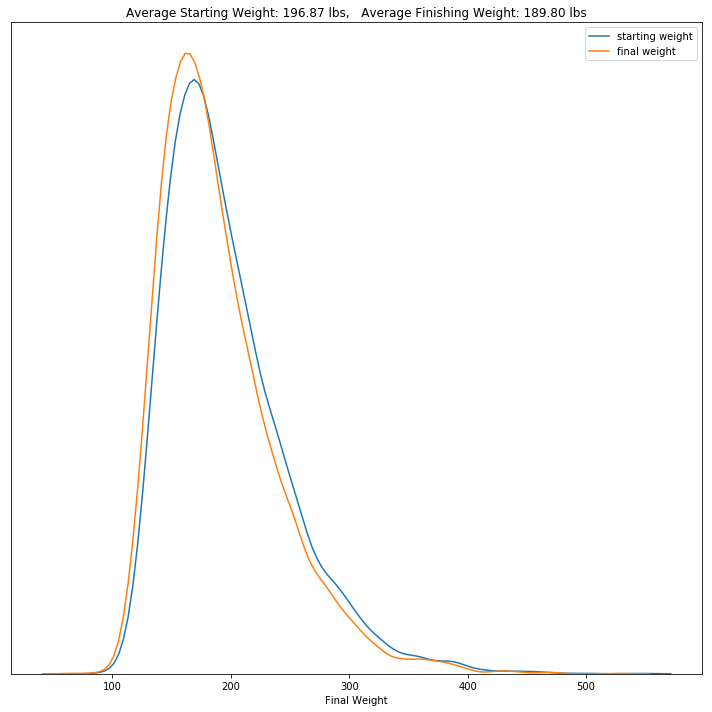

In [92]:
plt.figure(figsize=(10,10))
ax = sns.distplot(big_df['Starting Weight'], hist=False, label='starting weight')
ax = sns.distplot(big_df['Final Weight'], hist=False, label='final weight')
ax.set_yticks([])
ax.set_title(f'Average Starting Weight: {big_df["Starting Weight"].mean():.2f} lbs,   Average Finishing Weight: {big_df["Final Weight"].mean():.2f} lbs')
ax.legend()
plt.tight_layout()
plt.savefig('./figures/starting_final_weight.png', dpi=400)

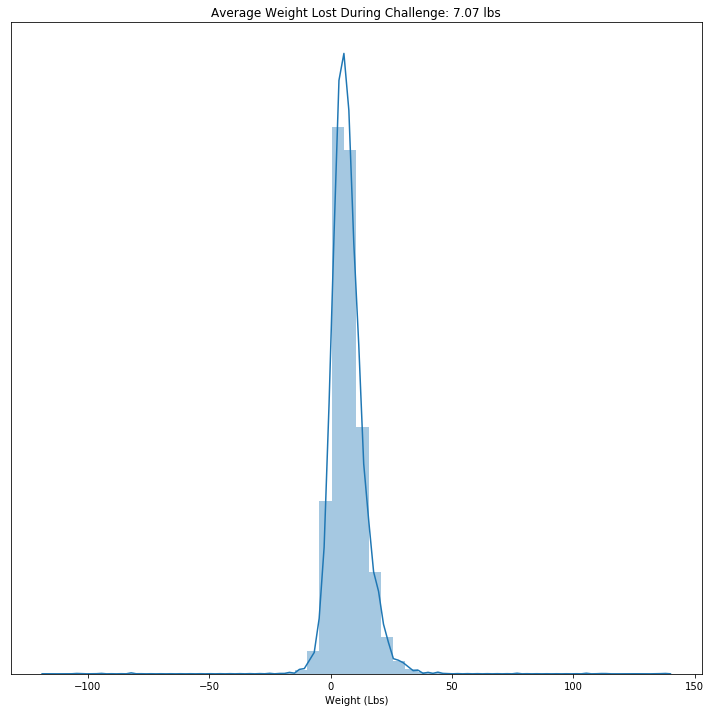

In [88]:
plt.figure(figsize=(10,10))
ax = sns.distplot(big_df['Total Challenge Loss'])
ax.set_xlabel('Weight (Lbs)')
ax.set_title(f'Average Weight Lost During Challenge: {big_df["Total Challenge Loss"].mean():.2f} lbs')
ax.set_yticks([])
plt.tight_layout()
plt.savefig('./figures/average_weight_lost.png', dpi=400)

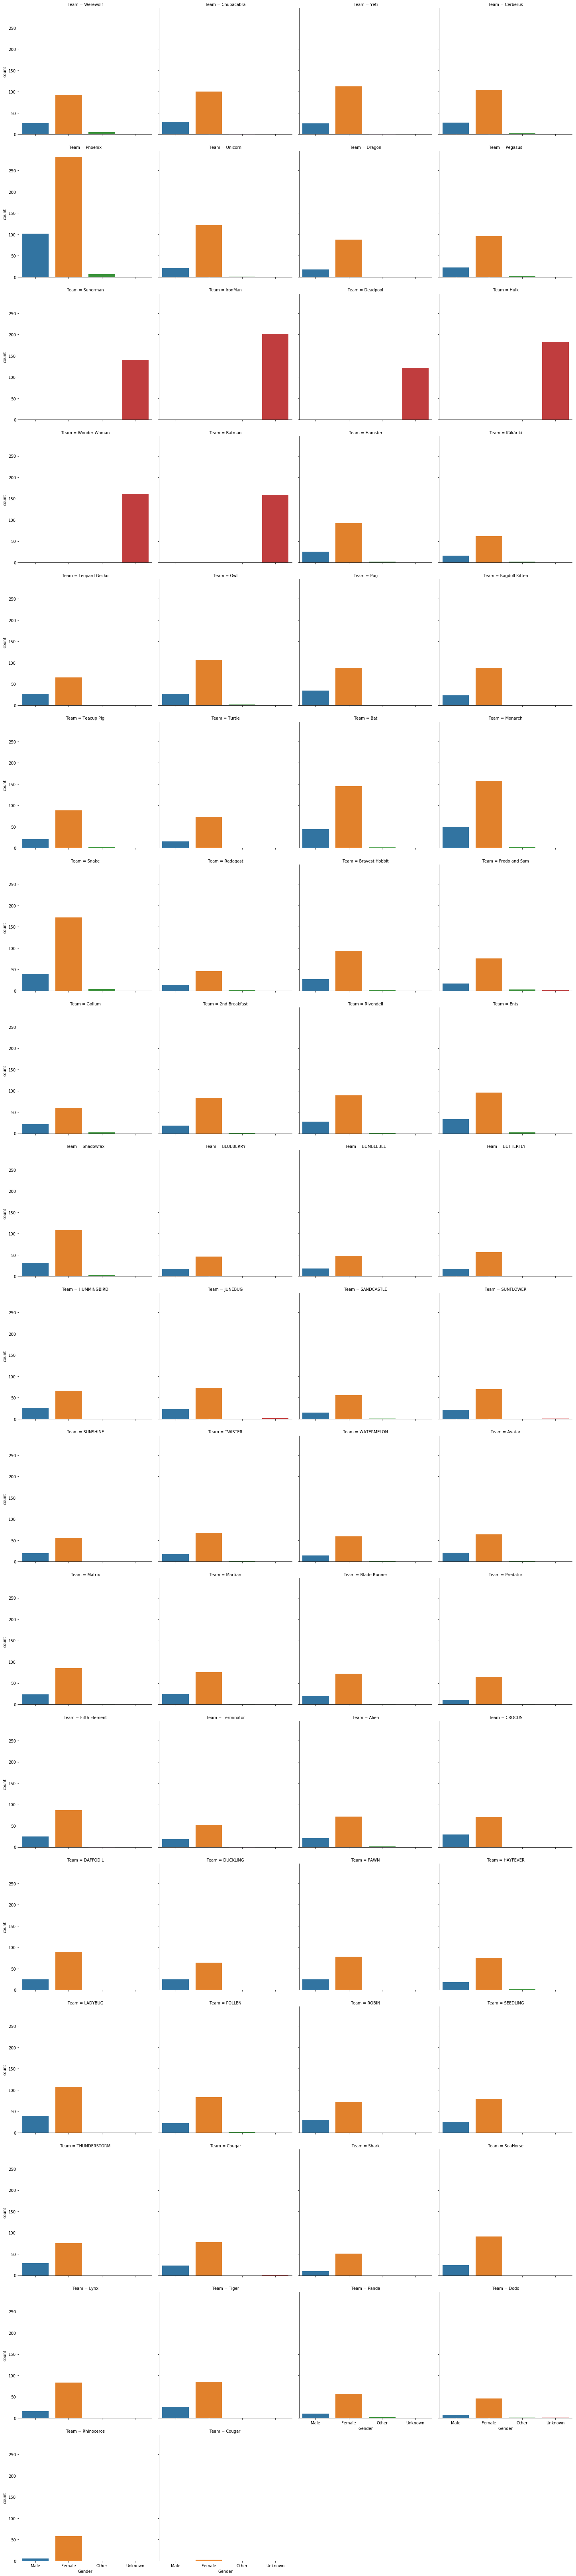

In [65]:
sns.catplot(x='Gender', kind="count", data=big_df, col='Team', col_wrap=4, height=5)

In [57]:
weight_cols

array(['Week 0', 'Week 1', 'Week 2', 'Week 3', 'Week 4', 'Week 5',
       'Week 6', 'Week 7'], dtype=object)

In [199]:
li = ['Week 2', 'Week 3', 'Week 4', 'Week 5', 'Week 6', 'Week 7', 'Week 8', 'Week 9', 'Week 10', 'Week 0']
li

['Week 2',
 'Week 3',
 'Week 4',
 'Week 5',
 'Week 6',
 'Week 7',
 'Week 8',
 'Week 9',
 'Week 10',
 'Week 0']

In [201]:
li.sort()
li

['Week 0',
 'Week 10',
 'Week 2',
 'Week 3',
 'Week 4',
 'Week 5',
 'Week 6',
 'Week 7',
 'Week 8',
 'Week 9']

In [ ]:
df = df[df.columns.values[:12].tolist() + new_cols + weight_cols.tolist()]

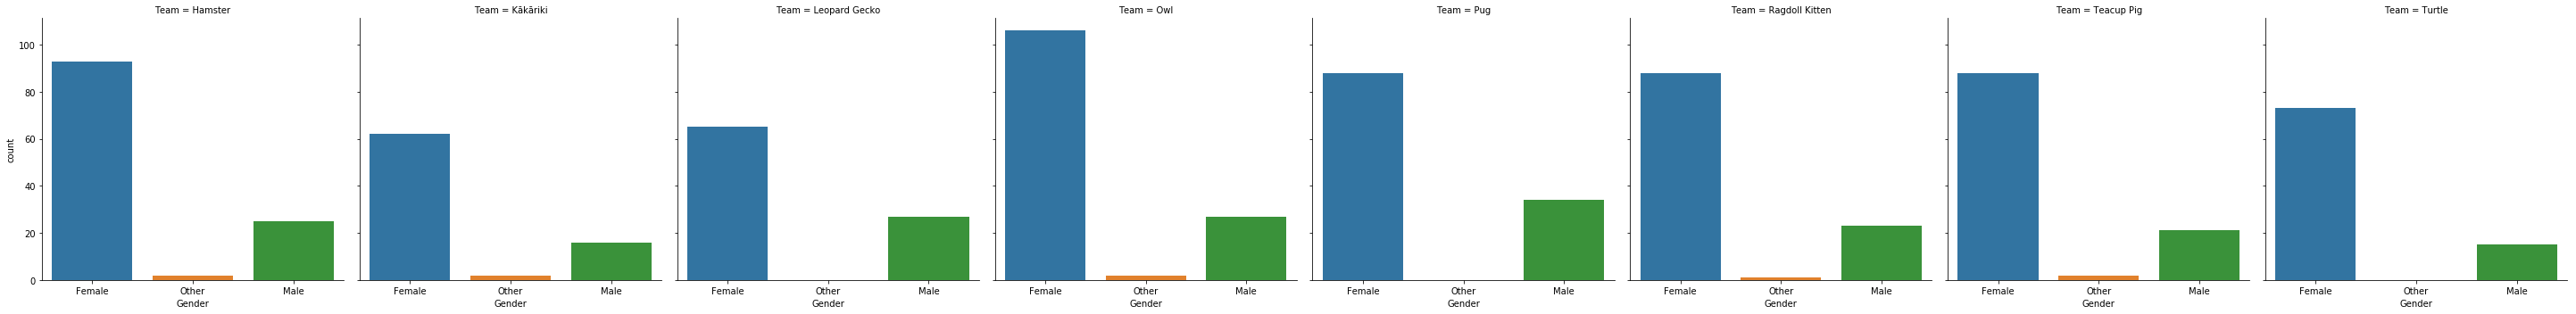

In [36]:
sns.catplot(x='Gender', kind="count", data=df, col='Team')

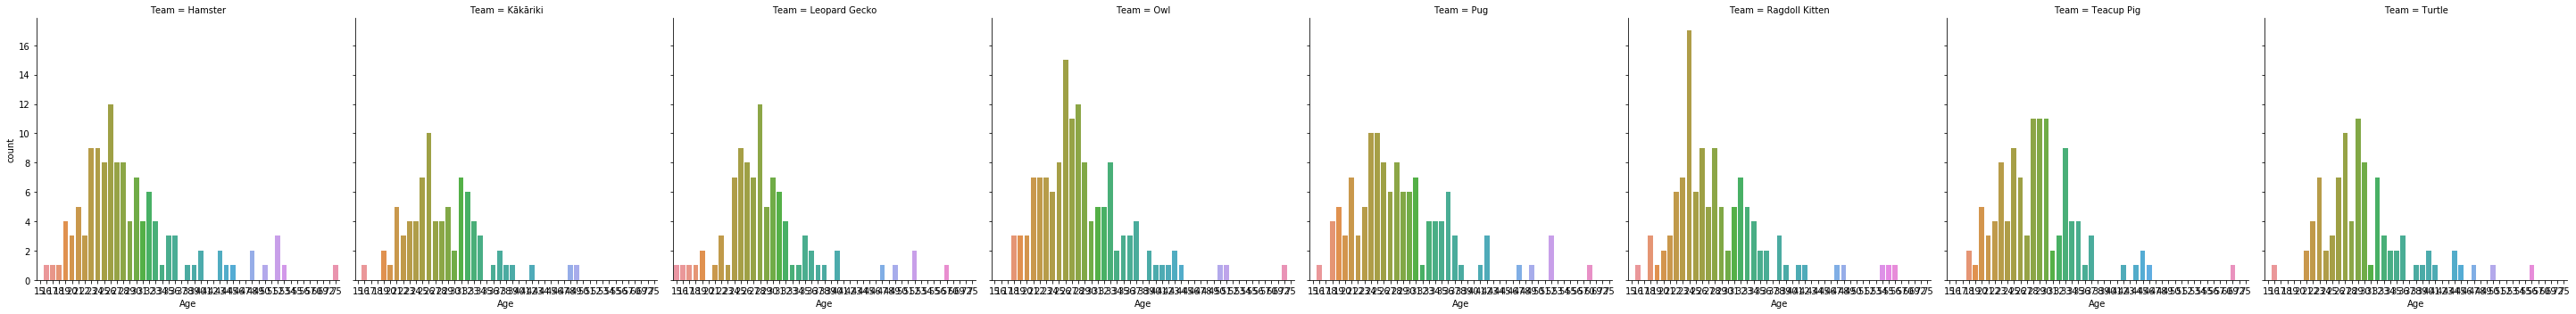

In [37]:
sns.catplot(x='Age', kind="count", data=df, col='Team')

In [ ]:
f, ax = plt.subplots(1, 1)
ax = sns.distplot(df['Week 0'], label='starting weight')
ax = sns.distplot(df['Week 6'], label='final week')
ax.legend()

In [ ]:
df.n

### Now we want to fill in any other missing info

In [ ]:
p = Path('./data/')
for challenge in p.rglob('Cleaned*.csv'):
    df = pd.read_csv(challenge, index_col=0)
    print(challenge.stem, df.count())

In [ ]:
test_df.loc[(test_df.shape[1] - 2) <= test_df.count(axis=1)]#.fillna(axis=1, method='ffill')
lb = test_df.filter(regex=re.compile("Height", re.IGNORECASE)).columns[0]
print(lb, lb in test_df)
test_df.columns.str.replace(test_df.columns.sort_values()[-1], 'Height')

In [ ]:
test_df[test_df.columns.sort_values()[-1]]

In [ ]:
f_df = df[df['Gender']!='Male']
o_df = f_df[f_df.Gender != 'Female']
o_df

In [ ]:
sns.catplot(x='Gender', kind="count", data=df)

In [ ]:
test_df.columns

In [ ]:
f, ax = plt.subplots(1, 1)
ax = sns.distplot(test_df['Week 0'],label='starting weight')
ax = sns.distplot(test_df['Week 6'], label='final week')
ax.legend()